In [2]:
!pip install maraboupy
!pip install --upgrade onnx onnxscript onnxruntime
!pip install tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 re

In [3]:
from maraboupy import Marabou
from maraboupy import MarabouCore
import numpy as np
import torch
import torch.nn as nn
import onnx
import onnxruntime as ort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import psutil
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
file_path = "/content/Diabetes Dataset.csv"
diabetes_data = pd.read_csv(file_path)
input = diabetes_data.drop("Outcome", axis=1).values
truth = diabetes_data["Outcome"].values

X_train, X_test, y_train, y_test = train_test_split(input, truth, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Defining the classifier class

In [6]:
class NNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NNClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, num_classes)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        return x

In [7]:
def modeltrainer(input_size, hidden_size1, hidden_size2, num_classes, epochs=100):
    model = NNClassifier(input_size, hidden_size1, hidden_size2, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch+1) % 20 == 0:
            print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}', end='\t')
            model.eval()
            with torch.no_grad():
                outputs = model(X_test_tensor)
                _, predicted = torch.max(outputs, 1)
                accuracy = accuracy_score(y_test_tensor, predicted)
                print(f'Test Accuracy: {accuracy:.4f}')

    return model

In [8]:
architectures = [
    (16, 16, 8, 2),       # smaller network
    (16, 128, 64, 2),      # medium network
    (16, 768, 256, 2),    # large network
]
trained_models = {}
for arch in architectures:
    input_size, hidden_size1, hidden_size2, num_classes = arch
    print(f"\narchitecture {arch}...")
    model = modeltrainer(input_size, hidden_size1, hidden_size2, num_classes)
    trained_models[arch] = model


architecture (16, 16, 8, 2)...
Epoch 20, Loss: 0.0352	Test Accuracy: 0.9832
Epoch 40, Loss: 0.0184	Test Accuracy: 0.9911
Epoch 60, Loss: 0.0118	Test Accuracy: 0.9942
Epoch 80, Loss: 0.0085	Test Accuracy: 0.9948
Epoch 100, Loss: 0.0064	Test Accuracy: 0.9953

architecture (16, 128, 64, 2)...
Epoch 20, Loss: 0.0111	Test Accuracy: 0.9916
Epoch 40, Loss: 0.0033	Test Accuracy: 0.9953
Epoch 60, Loss: 0.0008	Test Accuracy: 0.9942
Epoch 80, Loss: 0.0002	Test Accuracy: 0.9948
Epoch 100, Loss: 0.0000	Test Accuracy: 0.9942

architecture (16, 768, 256, 2)...
Epoch 20, Loss: 0.0030	Test Accuracy: 0.9953
Epoch 40, Loss: 0.0001	Test Accuracy: 0.9953
Epoch 60, Loss: 0.0000	Test Accuracy: 0.9963
Epoch 80, Loss: 0.0000	Test Accuracy: 0.9958
Epoch 100, Loss: 0.0000	Test Accuracy: 0.9963


In [9]:
print(trained_models)
small_model = trained_models[(16, 16, 8, 2)]
torch.save(small_model.state_dict(), 'small_model.pth')
medium_model = trained_models[(16, 128, 64, 2)]
torch.save(medium_model.state_dict(), 'medium_model.pth')
large_model = trained_models[(16, 768, 256, 2)]
torch.save(large_model.state_dict(), 'large_model.pth')

{(16, 16, 8, 2): NNClassifier(
  (layer1): Linear(in_features=16, out_features=16, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=8, out_features=2, bias=True)
), (16, 128, 64, 2): NNClassifier(
  (layer1): Linear(in_features=16, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=64, out_features=2, bias=True)
), (16, 768, 256, 2): NNClassifier(
  (layer1): Linear(in_features=16, out_features=768, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=768, out_features=256, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=256, out_features=2, bias=True)
)}


In [10]:
def convert_to_onnx(model, input_size, path='model.onnx'):
    model.eval()
    dummy_input = torch.randn(1, input_size)

    torch.onnx.export(model,
                      dummy_input,
                      path,
                      export_params=True,
                      opset_version=11,
                      do_constant_folding=True,
                      input_names=['input'],
                      output_names=['output'],
                      dynamic_axes={'input': {0: 'batch_size'},
                                    'output': {0: 'batch_size'}})

    print(f"Model exported to {path}")
    return path

In [11]:
def verify_property_simple(network, feature_constraints, expected_class, timeout=600):
    try:
        # resetting network constraints
        network = Marabou.read_onnx(onnx_path)

        # tracking checked parameters
        constrained_indices = set()

        # set constraints
        for idx, lb, ub in feature_constraints:
            input_var = network.inputVars[0].flatten()[idx]
            network.setLowerBound(input_var, lb)
            network.setUpperBound(input_var, ub)
            constrained_indices.add(idx)

        # set reasonable bounds for unconstrained features ±3 standard deviations, covers 99.7% of values
        for i, var in enumerate(network.inputVars[0].flatten()):
            if i not in constrained_indices:
                network.setLowerBound(var, -3.0)
                network.setUpperBound(var, 3.0)

        # set output bounds to check for counter-examples
        outputVars = network.outputVars[0].flatten()

        if expected_class == 0:
            network.setUpperBound(outputVars[0], 0)  # force output[0] to be negative
            network.setLowerBound(outputVars[1], 0)  # force output[1] to be positive
        else:
            # set output[1] < output[0]
            network.setUpperBound(outputVars[1], 0)  # forces output[1] to be negative
            network.setLowerBound(outputVars[0], 0)  #forces output[0] to be positive

        options = MarabouCore.Options()
        options._timeoutInSeconds = timeout

        result = network.solve(options)

        if result[0]:  # SAT - counter-example
            print(f"Property VIOLATED: Found a counterexample where the expected classification to class {expected_class} is not guaranteed.")
            print( "sat")
        else:  # UNSAT - Property holds
            print(f"Property HOLDS: All inputs with the given constraints produce expected classification to class {expected_class}.")
            print( "unsat")

    except Exception as e:
        print(f"Error during verification: {e}")
        import traceback
        traceback.print_exc()
        return "error"

In [12]:
model = NNClassifier(16, 16, 8, 2)
model.load_state_dict(torch.load('small_model.pth'))
model.eval()
onnx_path = convert_to_onnx(model, 16)

Model exported to model.onnx


In [13]:
print("Feature indices for reference:")
diabetes_features = diabetes_data.columns.drop("Outcome").tolist()
for i, name in enumerate(diabetes_features[:10]):
    print(f"{i}: {name}")

print("\nVerifying Property 1: High Glucose leads to diabetes classification")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[(3, 1.5, 3.0)],
    expected_class=1
)

print("\nVerifying Property 2: Low HDL leads to diabetes classification")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[(7, -3.0, -1.5)],
    expected_class=1
)

print("\nVerifying Property 3: Robustness around a non-diabetic example")
non_diabetic_idx = np.where(y_test == 0)[0][0]
non_diabetic_example = X_test[non_diabetic_idx]
feature_constraints = [(i, non_diabetic_example[i] - 0.1, non_diabetic_example[i] + 0.1) for i in range(5)]
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=feature_constraints,
    expected_class=0
)

print("\nVerifying Property 4: Moderate values should not give extreme predictions")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[
        (3, -0.5, 0.5),
        (5, -0.5, 0.5),
        (2, -0.5, 0.5),
        (8, -0.5, 0.5)
    ],
    expected_class=0
)

print("\nVerifying Property 5: Multiple diabetes indicators lead to positive classification")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[
        (3, 1.5, 3.0),
        (5, 1.5, 3.0),
        (2, 1.5, 3.0),
        (9, 1.5, 3.0)
    ],
    expected_class=1
)

Feature indices for reference:
0: Age
1: Pregnancies
2: BMI
3: Glucose
4: BloodPressure
5: HbA1c
6: LDL
7: HDL
8: Triglycerides
9: WaistCircumference

Verifying Property 1: High Glucose leads to diabetes classification
sat
input 0 = -3.0
input 1 = -3.0
input 2 = -3.0
input 3 = 1.5
input 4 = -3.0
input 5 = -3.0
input 6 = -3.0
input 7 = -3.0
input 8 = -3.0
input 9 = -3.0
input 10 = -3.0
input 11 = -3.0
input 12 = -1.5420082717161896
input 13 = -3.0
input 14 = 1.780454097965662
input 15 = -3.0
output 0 = 4.108743550527126
output 1 = -5.865666229649038
Property VIOLATED: Found a counterexample where the expected classification to class 1 is not guaranteed.
sat

Verifying Property 2: Low HDL leads to diabetes classification
sat
input 0 = -3.0
input 1 = -3.0
input 2 = -3.0
input 3 = -0.5637319692462781
input 4 = -3.0
input 5 = -3.0
input 6 = -3.0
input 7 = -2.399969987887769
input 8 = -3.0
input 9 = -3.0
input 10 = -3.0
input 11 = -3.0
input 12 = -0.5676897534294476
input 13 = -3.0
input 14 

In [14]:
model = NNClassifier(16, 768, 256, 2)
model.load_state_dict(torch.load('large_model.pth'))
model.eval()

onnx_path = convert_to_onnx(model, 16)

Model exported to model.onnx


In [15]:
print("Feature indices for reference:")
diabetes_features = diabetes_data.columns.drop("Outcome").tolist()
for i, name in enumerate(diabetes_features[:10]):  # First 10 features
    print(f"{i}: {name}")

# Define and test properties using standardized features
print("\nVerifying Property 1: High Glucose leads to diabetes classification")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[(3, 1.5, 3.0)],  # Glucose (index 3) - high standardized values
    expected_class=1  # Diabetes
)

print("\nVerifying Property 2: Low HDL leads to diabetes classification")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[(7, -3.0, -1.5)],  # HDL (index 7) - low standardized values
    expected_class=1  # Diabetes
)

print("\nVerifying Property 3: Robustness around a non-diabetic example")
non_diabetic_idx = np.where(y_test == 0)[0][0]
non_diabetic_example = X_test[non_diabetic_idx]
# Constrain first 5 features (Age, Pregnancies, BMI, Glucose, BP)
feature_constraints = [(i, non_diabetic_example[i] - 0.1, non_diabetic_example[i] + 0.1) for i in range(5)]
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=feature_constraints,
    expected_class=0  # Non-diabetic
)

print("\nVerifying Property 4: Moderate values should not give extreme predictions")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[
        (3, -0.5, 0.5),  # Glucose
        (5, -0.5, 0.5),  # HbA1c
        (2, -0.5, 0.5),  # BMI
        (8, -0.5, 0.5)   # Triglycerides
    ],
    expected_class=0  # Not extremely confident in diabetes
)

print("\nVerifying Property 5: Multiple diabetes indicators lead to positive classification")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[
        (3, 1.5, 3.0),   # High Glucose
        (5, 1.5, 3.0),   # High HbA1c
        (2, 1.5, 3.0),   # High BMI
        (9, 1.5, 3.0)    # High WaistCircumference
    ],
    expected_class=1  # Diabetes
)

Feature indices for reference:
0: Age
1: Pregnancies
2: BMI
3: Glucose
4: BloodPressure
5: HbA1c
6: LDL
7: HDL
8: Triglycerides
9: WaistCircumference

Verifying Property 1: High Glucose leads to diabetes classification
sat
input 0 = 0.21900057664808728
input 1 = 0.28239755964283453
input 2 = 0.4148154480831108
input 3 = 1.5
input 4 = 0.4909054566398563
input 5 = 0.4491690459539936
input 6 = 0.41950237985316546
input 7 = 0.34406226439732157
input 8 = -0.12149966463129115
input 9 = 0.8744363888966161
input 10 = 0.5485436541898988
input 11 = 0.05108297150151326
input 12 = -0.7662918097600396
input 13 = 0.25918106494823434
input 14 = 0.5334933465712008
input 15 = 0.5356850045132743
output 0 = 0.3758363983325861
output 1 = 0.0
Property VIOLATED: Found a counterexample where the expected classification to class 1 is not guaranteed.
sat

Verifying Property 2: Low HDL leads to diabetes classification
sat
input 0 = 0.169396541594669
input 1 = -0.00022273288671120948
input 2 = 0.4996800261107526

In [17]:
model = NNClassifier(16, 128, 64, 2)
model.load_state_dict(torch.load('medium_model.pth'))
model.eval()

onnx_path = convert_to_onnx(model, 16)

Model exported to model.onnx


In [18]:
print("Feature indices for reference:")
diabetes_features = diabetes_data.columns.drop("Outcome").tolist()
for i, name in enumerate(diabetes_features[:10]):  # First 10 features
    print(f"{i}: {name}")

# Define and test properties using standardized features
print("\nVerifying Property 1: High Glucose leads to diabetes classification")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[(3, 1.5, 3.0)],  # Glucose (index 3) - high standardized values
    expected_class=1  # Diabetes
)

print("\nVerifying Property 2: Low HDL leads to diabetes classification")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[(7, -3.0, -1.5)],  # HDL (index 7) - low standardized values
    expected_class=1  # Diabetes
)

print("\nVerifying Property 3: Robustness around a non-diabetic example")
non_diabetic_idx = np.where(y_test == 0)[0][0]
non_diabetic_example = X_test[non_diabetic_idx]
# Constrain first 5 features (Age, Pregnancies, BMI, Glucose, BP)
feature_constraints = [(i, non_diabetic_example[i] - 0.1, non_diabetic_example[i] + 0.1) for i in range(5)]
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=feature_constraints,
    expected_class=0  # Non-diabetic
)

print("\nVerifying Property 4: Moderate values should not give extreme predictions")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[
        (3, -0.5, 0.5),  # Glucose
        (5, -0.5, 0.5),  # HbA1c
        (2, -0.5, 0.5),  # BMI
        (8, -0.5, 0.5)   # Triglycerides
    ],
    expected_class=0  # Not extremely confident in diabetes
)

print("\nVerifying Property 5: Multiple diabetes indicators lead to positive classification")
verify_property_simple(
    network=Marabou.read_onnx(onnx_path),
    feature_constraints=[
        (3, 1.5, 3.0),   # High Glucose
        (5, 1.5, 3.0),   # High HbA1c
        (2, 1.5, 3.0),   # High BMI
        (9, 1.5, 3.0)    # High WaistCircumference
    ],
    expected_class=1  # Diabetes
)

Feature indices for reference:
0: Age
1: Pregnancies
2: BMI
3: Glucose
4: BloodPressure
5: HbA1c
6: LDL
7: HDL
8: Triglycerides
9: WaistCircumference

Verifying Property 1: High Glucose leads to diabetes classification
sat
input 0 = -0.8308902941281341
input 1 = -0.33920120255499514
input 2 = -0.3642424884338763
input 3 = 1.5
input 4 = 0.564802596051814
input 5 = 0.1715737005891456
input 6 = 0.12502038935989152
input 7 = -0.001680895568098477
input 8 = 0.17224280279874912
input 9 = -0.29337468983218207
input 10 = 0.24404904608121147
input 11 = -0.025685151599188546
input 12 = -0.6969822666111487
input 13 = -0.19969523392793906
input 14 = 0.6547933057348457
input 15 = 0.5272741498636475
output 0 = 0.2500304254945786
output 1 = 0.0
Property VIOLATED: Found a counterexample where the expected classification to class 1 is not guaranteed.
sat

Verifying Property 2: Low HDL leads to diabetes classification
sat
input 0 = -0.29498855374554184
input 1 = 0.007876540394746568
input 2 = -0.2681988

Question 3

In [20]:
from typing import Dict, Any
import time

def benchmark_verification(
    network,
    property_constraints: list,
    expected_class: int,
    timeout: int = 600
) -> Dict[str, Any]:

    result = {
        "result": "error",
        "time": 0.0,
        "success": False,
        "error": None
    }

    start_time = time.perf_counter()

    try:
        verification_result = verify_property_simple(
            network,
            property_constraints,
            expected_class,
            timeout
        )

        result.update({
            "result": verification_result,
            "success": True,
        })

    except MarabouError as e:
        result["error"] = f"Marabou verification failed: {str(e)}"
    except TimeoutError:
        result["error"] = f"Verification timed out after {timeout}s"
    except Exception as e:
        result["error"] = f"Unexpected error: {str(e)}"
    finally:
        # Calculate execution time
        result["time"] = time.perf_counter() - start_time

    if result["error"]:
        print(f"Verification error: {result['error']}")

    return result

In [21]:
def get_varying_specifications():
    specs = []

    specs.append({
        "name": "High Glucose -> Diabetes",
        "constraints": [(3, 1.5, 3.0)],
        "expected_class": 1
    })

    specs.append({
        "name": "High Glucose and HbA1c -> Diabetes",
        "constraints": [(3, 1.5, 3.0), (5, 1.5, 3.0)],
        "expected_class": 1
    })

    specs.append({
        "name": "Metabolic syndrome profile",
        "constraints": [
            (3, 1.5, 3.0),   # High Glucose
            (5, 1.5, 3.0),   # High HbA1c
            (2, 1.5, 3.0),   # High BMI
            (7, -3.0, -1.5), # Low HDL (good cholesterol)
            (9, 1.5, 3.0)    # High WaistCircumference
        ],
        "expected_class": 1
    })

    specs.append({
        "name": "Borderline HbA1c/Glucose",
        "constraints": [
            (3, 0.9, 1.1),  # Near-diabetic glucose
            (5, 0.9, 1.1)   # Near-diabetic HbA1c
        ],
        "expected_class": 1
    })

    specs.append({
        "name": "Healthy profile",
        "constraints": [
            (3, -2.0, -1.0),  # Low Glucose
            (5, -2.0, -1.0),   # Low HbA1c
            (2, -1.5, 0.5),    # Normal BMI
            (7, 0.5, 2.0)      # High HDL
        ],
        "expected_class": 0
    })

    return specs

In [24]:
def run_benchmarking():
    results = []

    # Use models with input_size=16 features
    width_networks = {
        "small_model": small_model,
        'medium_model': medium_model,
        "large_model": large_model
    }

    specifications = get_varying_specifications()

    for network_name, network in width_networks.items():
        onnx_path = convert_to_onnx(network, 16, f'diabetes_{network_name}.onnx')
        marabou_network = Marabou.read_onnx(onnx_path)

        for spec in specifications:
            print(f"Testing {network_name} with {spec['name']}")
            result = benchmark_verification(
                marabou_network,
                spec['constraints'],
                spec['expected_class']
            )

            result.update({
                "network": network_name,
                "specification": spec['name'],
                "architecture_type": "width_variation",
                "dataset": "diabetes"
            })

            results.append(result)

    return results

Model exported to diabetes_small_model.onnx
Testing small_model with High Glucose -> Diabetes
sat
input 0 = -0.8308902941281341
input 1 = -0.33920120255499514
input 2 = -0.3642424884338763
input 3 = 1.5
input 4 = 0.564802596051814
input 5 = 0.1715737005891456
input 6 = 0.12502038935989152
input 7 = -0.001680895568098477
input 8 = 0.17224280279874912
input 9 = -0.29337468983218207
input 10 = 0.24404904608121147
input 11 = -0.025685151599188546
input 12 = -0.6969822666111487
input 13 = -0.19969523392793906
input 14 = 0.6547933057348457
input 15 = 0.5272741498636475
output 0 = 0.2500304254945786
output 1 = 0.0
Property VIOLATED: Found a counterexample where the expected classification to class 1 is not guaranteed.
sat
Testing small_model with High Glucose and HbA1c -> Diabetes
sat
input 0 = -0.597224937725953
input 1 = -0.4226779581497036
input 2 = 0.11007388192248943
input 3 = 1.5
input 4 = -0.3348965707237496
input 5 = 1.6983161232979431
input 6 = 0.6427396168134917
input 7 = -0.1638911

,result,time,success,error,network,specification,architecture_type,dataset
0,None,0.219505,True,None,small_model,High Glucose -> Diabetes,width_variation,diabetes
1,None,0.325448,True,None,small_model,High Glucose and HbA1c -> Diabetes,width_variation,diabetes
2,None,0.417587,True,None,small_model,Metabolic syndrome profile,width_variation,diabetes
3,None,0.549434,True,None,small_model,Borderline HbA1c/Glucose,width_variation,diabetes
4,None,0.700633,True,None,small_model,Healthy profile,width_variation,diabetes
5,None,1.327650,True,None,medium_model,High Glucose -> Diabetes,width_variation,diabetes
6,None,0.940552,True,None,medium_model,High Glucose and HbA1c -> Diabetes,width_variation,diabetes
7,None,0.346578,True,None,medium_model,Metabolic syndrome profile,width_variation,diabetes
8,None,0.291306,True,None,medium_model,Borderline HbA1c/Glucose,width_variation,diabetes
9,None,0.218670,True,None,medium_model,Healthy profile,width_variation,diabetes


<Figure size 1200x800 with 0 Axes>

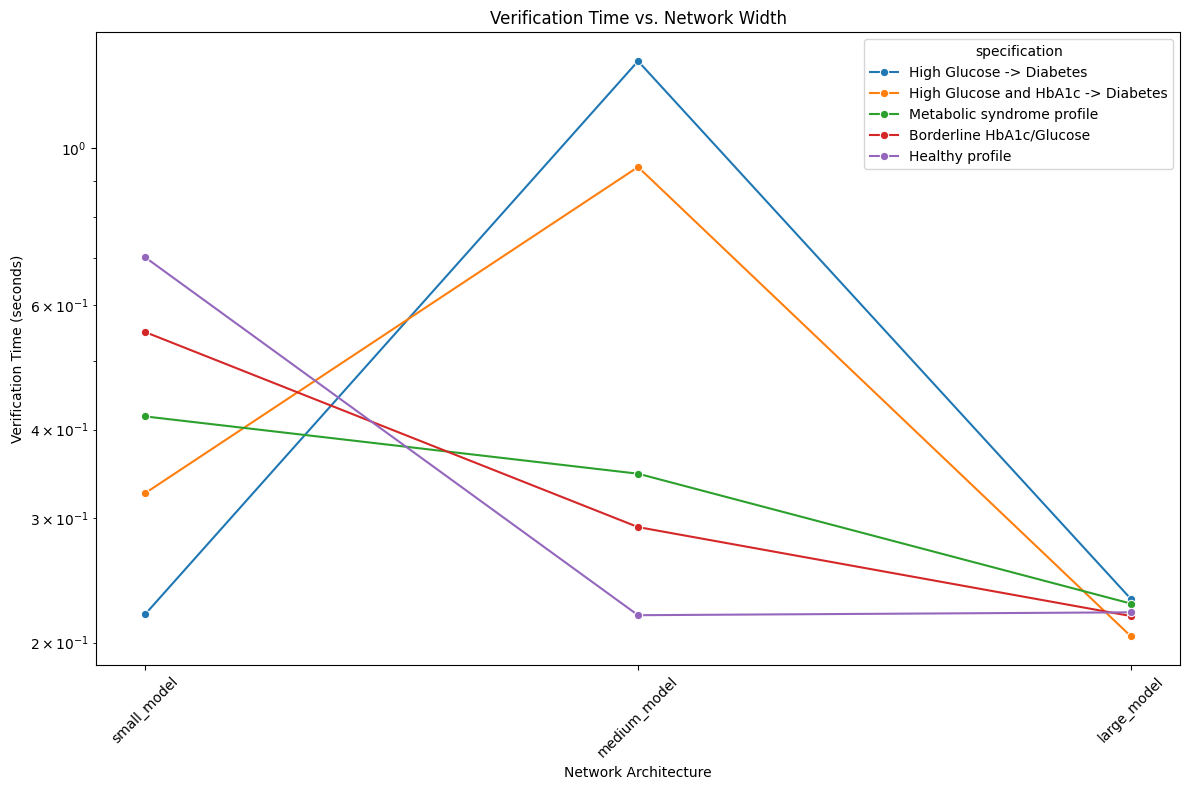

In [25]:
def analyze_results(results):
    df = pd.DataFrame(results)
    plt.figure(figsize=(12, 8))
    plt.figure(figsize=(12, 8))
    width_df = df[df['architecture_type'] == 'width_variation']
    sns.lineplot(data=width_df, x='network', y='time', hue='specification', marker='o')
    plt.title('Verification Time vs. Network Width')
    plt.xlabel('Network Architecture')
    plt.ylabel('Verification Time (seconds)')
    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.tight_layout()

    success_by_arch = df.groupby(['architecture_type', 'network'])['success'].mean()
    print("Success rate by architecture:")
    print(success_by_arch)

    return df

results = run_benchmarking()
analyze_results(results)